In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Regular Imports
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
from tqdm import tqdm

import inference.scheduler
from inference.distribution import Gaussian, Rosenbrock2D, InterpolatedDensity
from inference.sde import EulerMaruyamaSimulator, LangevinDynamics
import utils.vis2d.visualization

In [61]:
x_min, x_max = (-1,1)
y_min, y_max = (-1,1)
x = torch.linspace(x_min, x_max, bins).to(device) 
y = torch.linspace(y_min, y_max, bins).to(device)
X, Y = torch.meshgrid(x, y)
xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)

field = density_field(xy).reshape(bins, bins)

In [62]:
field

tensor([[-2.8379, -2.8339, -2.8299,  ..., -2.8299, -2.8339, -2.8379],
        [-2.8339, -2.8299, -2.8259,  ..., -2.8259, -2.8299, -2.8339],
        [-2.8299, -2.8259, -2.8219,  ..., -2.8219, -2.8259, -2.8299],
        ...,
        [-2.8299, -2.8259, -2.8219,  ..., -2.8219, -2.8259, -2.8299],
        [-2.8339, -2.8299, -2.8259,  ..., -2.8259, -2.8299, -2.8339],
        [-2.8379, -2.8339, -2.8299,  ..., -2.8299, -2.8339, -2.8379]])

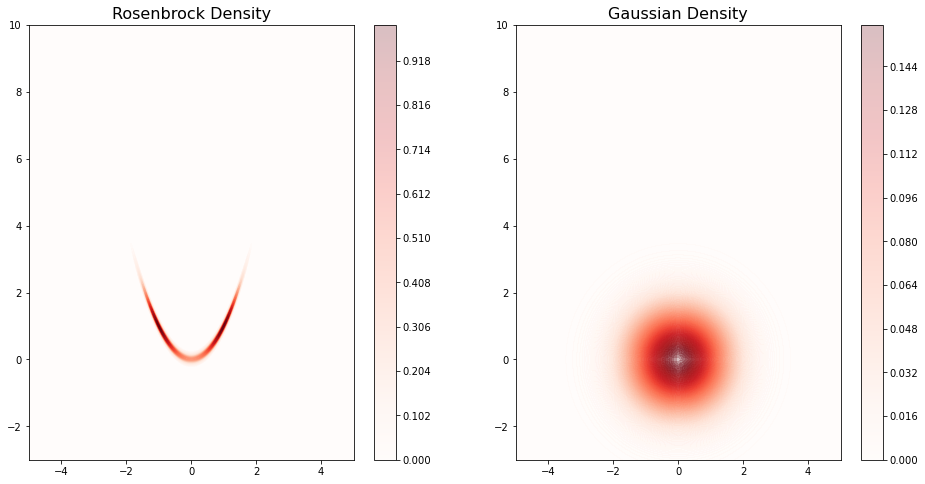

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Ensure square figure size
x_bounds, y_bounds = (-5, 5), (-3, 10)
bins = 500

# Rosenbrock
distribution = Rosenbrock2D(a=100,b=1.0)
density_field = lambda x: torch.exp(distribution.log_density(x))

utils.vis2d.visualization.visualize_contours_scalarfield(
    density_field,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    ax=axes[0],
    bins=bins,
    device=device,
    alpha=0.25, cmap=plt.get_cmap('Reds'),
    show_colorbar=True,
)
axes[0].set_title('Rosenbrock Density', fontsize=16)

# Gaussian
distribution = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density_field = lambda x: torch.exp(distribution.log_density(x))
utils.vis2d.visualization.visualize_contours_scalarfield(
    density_field,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    ax=axes[1],
    bins=bins,
    device=device,
    alpha=0.25, cmap=plt.get_cmap('Reds'),
    show_colorbar=True,
)
axes[1].set_title('Gaussian Density', fontsize=16)
plt.show()

# Linear Interpolation of Scores

In [92]:
class LinearInterpolatedDensity(InterpolatedDensity):

    def __init__(self, density0, density1):
        super().__init__(density0, density1)
    
    def interpolate(self, log_density0: torch.Tensor, log_density1: torch.Tensor, alpha: float) -> torch.Tensor:
        """
        Constructs interpolation between density0 and density1
        Args:
            - log_density0 (torch.Tensor): Log density of density0 evaluated at x
            - log_density1 (torch.Tensor): Log density of density1 evaluated at x
            - alpha (float): Interpolation parameter (0 <= alpha <= 1)
        """
        return log_density0 + alpha * (log_density1 - log_density0)

### Testing Visualization of Interpolation

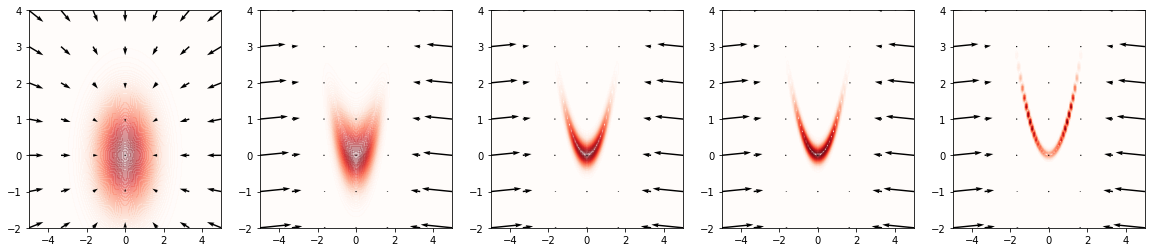

In [122]:
dist_interpolated = LinearInterpolatedDensity(density1=Rosenbrock2D(a=100,b=1.0), 
                                              density0=Gaussian(mean=torch.zeros(2), cov=torch.eye(2)))

alphas = [0.0, 0.01, 0.1, 0.2, 1.0]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Ensure square figure size
x_bounds, y_bounds = (-5, 5), (-2, 4)
for i, alpha in enumerate(alphas):
    density_field = lambda x: torch.exp(dist_interpolated.log_density(x, alpha=alpha))
    utils.vis2d.visualization.visualize_contours_scalarfield(
        density_field,
        x_bounds=x_bounds,
        y_bounds=y_bounds,
        ax=axes[i],
        bins=100,
        device=device,
        alpha=0.25, cmap=plt.get_cmap('Reds'),
        show_colorbar=False,
    )
    score = lambda x: dist_interpolated.score(x, alpha=alpha)
    utils.vis2d.visualization.visualize_vectorfield(vectorfield=score,
                                                    x_bounds=x_bounds,
                                                    y_bounds=y_bounds,
                                                    num_arrows=7,
                                                    ax=axes[i])

In [123]:
import torch
import matplotlib.pyplot as plt

from inference.distribution import InterpolatedDensity
from inference.simulator import Simulator

def run(dist: InterpolatedDensity, 
        x: torch.Tensor, 
        ts: torch.Tensor,
        noise_scheduler: inference.scheduler.Scheduler,
        interpolant_steps: torch.Tensor) -> torch.Tensor:    
    # Run Simulation
    xs = [x.clone()] 
    for step_pct in tqdm(interpolant_steps):
        score = lambda x, _: dist.score(x, alpha=step_pct)
        sde = LangevinDynamics(score=score, 
                               noise_scheduler=noise_scheduler)
        simulator = EulerMaruyamaSimulator(sde=sde)
        x = simulator.simulate(x=x, ts=ts) # shape (batch_size, dim)
        xs.append(x.clone())
    return torch.stack(xs, dim=1) # Shape (batch_size, interpolant_steps, dim)

def plot_trajectories_2d(x0: torch.Tensor,  
                         timesteps: torch.Tensor,
                         density: InterpolatedDensity,
                         noise_scheduler: inference.scheduler.Scheduler,
                         interpolant_steps: torch.Tensor,
                         x_bounds,
                         y_bounds,
                         show_num_steps: int = 5,):
    # Simulate Trajectories
    trajectories = run(dist=density, 
                       x=x0, 
                       ts=timesteps, 
                       noise_scheduler=noise_scheduler,
                       interpolant_steps=interpolant_steps) # Shape (batch_size, num_timesteps, dim)

    # Find slices to plot
    indices = torch.linspace(0, len(interpolant_steps)-1, show_num_steps, dtype=int)

    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=show_num_steps, figsize=(23, 4))
    for i, ax in enumerate(axes):
        index = indices[i]
        t = interpolant_steps[index]
        
        # Subplot settings
        ax.set_title(f"t = {t:.2f}")
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # Plot Current position of samples
        x = trajectories[:, index, 0]
        y = trajectories[:, index, 1]
        ax.scatter(x=x, y=y, alpha=0.9, s=10.0)

        # Plot Density
        logprob = lambda x: torch.exp(density.log_density(x, alpha=t))
        utils.vis2d.visualization.visualize_contours_scalarfield(
            logprob,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            ax=ax,
            bins=100,
            device=device,
            alpha=0.25, cmap=plt.get_cmap('Reds'),
            show_colorbar=True,
        )
        
        # # Plot Vector Field
        # score = lambda x: density.score(x, alpha=t)
        # utils.vis2d.visualization.visualize_vectorfield(vectorfield=score,
        #                                                 x_bounds=x_bounds,
        #                                                 y_bounds=y_bounds,
        #                                                 num_arrows=10,
        #                                                 ax=ax)
    return fig, axes



100%|██████████| 9/9 [00:15<00:00,  1.69s/it]


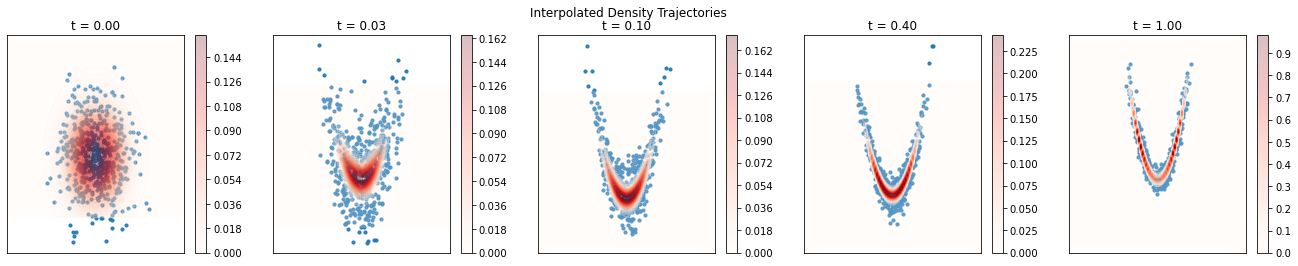

In [124]:
### Setup
# Distribution Setup
seed = 1

density0 = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density1 = Rosenbrock2D(a=100,b=1.0) # target distribution

# Simulator setup
noise_scheduler = inference.scheduler.Linear(3.0, 0.5)
x0 = density0.sample(num_samples=500)
interpolant_steps = torch.tensor([0.0, 0.01, 0.03, 0.06, 0.1, 0.2, 0.4, 0.7, 1.0])
num_steps, step_size = 1000, 0.001
ts = torch.arange(0, num_steps * step_size, step_size)

### Code
# Setup up
dist_interpolated = LinearInterpolatedDensity(density0=density0, density1=density1) # Interpolated density

x_bounds, y_bounds = (-5, 5), (-2, 4)
fig, axes = plot_trajectories_2d(x0=x0, 
                                 timesteps=ts, 
                                 density=dist_interpolated,
                                 noise_scheduler=noise_scheduler,
                                 interpolant_steps=interpolant_steps,
                                 x_bounds=x_bounds,
                                 y_bounds=y_bounds,)
fig.suptitle(f"Interpolated Density Trajectories")
plt.show()